Grab some packages we will need

In [8]:
#!/usr/bin/env python
from obspy.signal.spectral_estimation import get_nlnm, get_nhnm
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%matplotlib inline

Grab some data from an aftershock station from Ridgecrest.

In [9]:
client = Client()
stime = UTCDateTime('2019-194T02:05:40')
etime = UTCDateTime('2019-194T02:07:00')
st = client.get_waveforms("GS", "CA02", "*",
                           "H*Z", stime, etime, attach_response = True)
st.sort()
print(st)

2 Trace(s) in Stream:
GS.CA02.00.HHZ | 2019-07-13T02:05:40.000000Z - 2019-07-13T02:07:00.000000Z | 100.0 Hz, 8001 samples
GS.CA02.20.HNZ | 2019-07-13T02:05:40.000000Z - 2019-07-13T02:07:00.000000Z | 200.0 Hz, 16001 samples


We have two different sensors at the station (velocity and acceleration).  We can plot the responses to verify this.

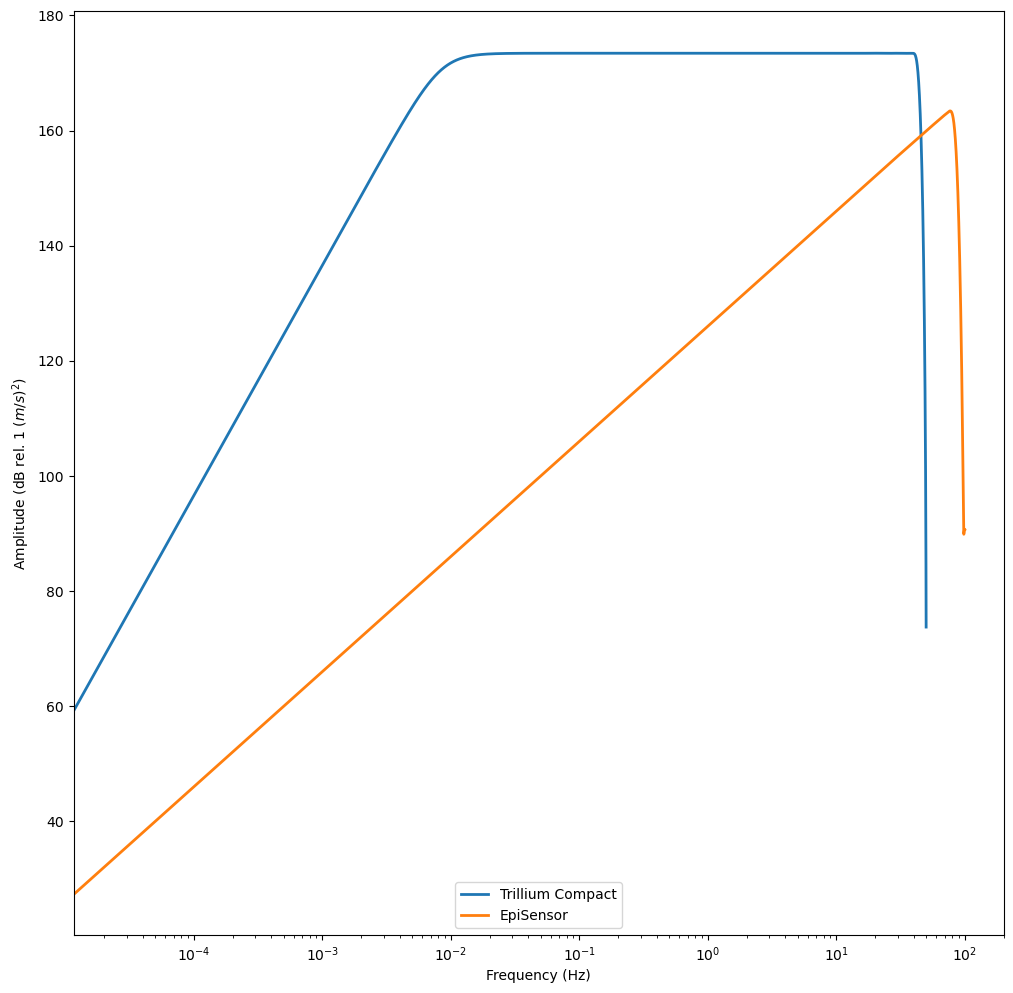

In [17]:
fig = plt.figure(1,figsize=(12,12))

for idx,  tr in enumerate(st):
    amp, f = tr.stats.response.get_evalresp_response(tr.stats.delta, 2**24, output='VEL')
    amp, f = amp[1:], f[1:]
    if idx == 0:
        label='Trillium Compact'
    else:
        label='EpiSensor'
    plt.semilogx(f, 20.*np.log10(np.abs(amp)), linewidth=2, label=label)
plt.legend(loc=8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB rel. 1 $(m/s)^2$)')
plt.xlim((1./(24*60*60), 200.));

Notice that the accelerometer it not flat to velocity but decreases with period.  However, if we convert both to acceleration, then we can compare them.

Question: What is the sensitivity of both sensors to DC (static signals)?


First we want to grab the New Low-Noise Model (NLNM) and New High-Noise Model (NHNM).

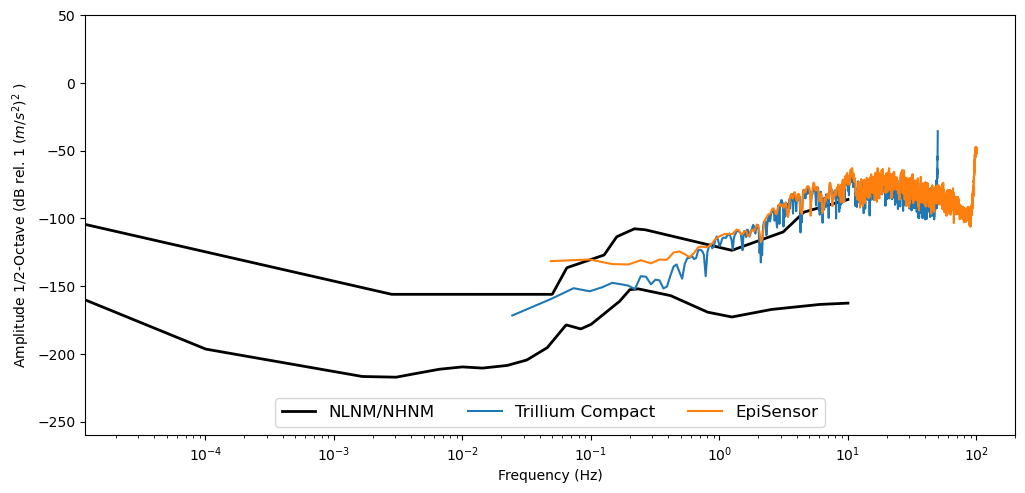

In [18]:
fig = plt.figure(1,figsize=(12,12))

# Grab a reference model and convert to acceleration
per, nlnm = get_nlnm()
per, nhnm = get_nhnm()
nlnm = np.sqrt(10**(nlnm/10.)*(2.**0.25 - 2.**(-0.25))/per)
nlnm = 20.*np.log10(nlnm)
nhnm = np.sqrt(10**(nhnm/10.)*(2.**0.25 - 2.**(-0.25))/per)
nhnm = 20.*np.log10(nhnm)
plt.text(1./(280*60*60), 180, '(a)', fontsize=26)
plt.subplot(2,1,2)
plt.semilogx(1./per, nlnm, color='k', linewidth=2)
plt.semilogx(1./per, nhnm, color='k', linewidth=2, label='NLNM/NHNM')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude 1/2-Octave (dB rel. 1 $(m/s^2)^2$ )')
plt.xlim((1./(24*60*60), 200.))

# Take our aftershock event and overlay all in acceleration

NFFT=4096
for idx, tr in enumerate(st):
    if idx == 0:
        label='Trillium Compact'
    else:
        label='EpiSensor'

    f, p = signal.welch(tr.data, fs = tr.stats.sampling_rate,
                     nperseg=NFFT, noverlap=256)
    f,p = f[1:], p[1:]
    amp, f= tr.stats.response.get_evalresp_response(tr.stats.delta, NFFT,
                                                    output='ACC')
    amp, f = amp[1:], f[1:]
    # (m/s^2)^2/Hz
    p /= np.abs(amp)**2
    # (m/s^2)^2
    p = p*(2.**0.25 - 2.**(-0.25))*f
    # dB rel octaves
    p=10.*np.log10(p)
    plt.semilogx(f,p, label=label)


plt.xlim((1./(24*60*60), 200.))
plt.legend(ncol=4, loc=8, fontsize=12)
plt.ylim((-260,50));


Questions: Why are the blue and organze curves above the NHNM?

Any guess why the Episensor doesn't overlay the compact at lower frequencies?

Why does the blue curve not go to higher frequencies?